# Causal Inference in Internal space using natural parameters and assuming Angle space responses

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import vonmises, circmean
from custom_causal_inference import CustomCausalInference
from repulsion_hypothesis import repulsion_value
import utils
import plots
import forward_models_causal_inference

c:\Users\Ana\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setup

In [2]:
num_sim = 1000
D = 250  # grid dimension 
angle_gam_data_path = 'D:/AK_Q1_2024/Gatsby/data/base_bayesian_contour_1_circular_gam/base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='D:/AK_Q1_2024/Gatsby/uniform_model_base_inv_kappa_free.pkl'
p_commons = [0, .2, .5, .7, 1]

causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
    model=CustomCausalInference(decision_rule='mean'),
    angle_gam_data_path=angle_gam_data_path,
    unif_fn_data_path=unif_fn_data_path)
unif_map = causal_inference_estimator.unif_map

<Figure size 576x432 with 0 Axes>

## Select the means of cues used for causal inference and the "ground-truth" corresponding responses 

Get the s_n, t, r_n(s_n, t) values of interest

In [13]:
s_n, t, r_n = utils.get_s_n_and_t(causal_inference_estimator.grid, 
                                   causal_inference_estimator.gam_data)
s_n.shape, t.shape, r_n.shape

((250, 250), (250, 250), (250, 250))

Further filer the values of s_n, t considered (and r_n implicitly) for faster simulations

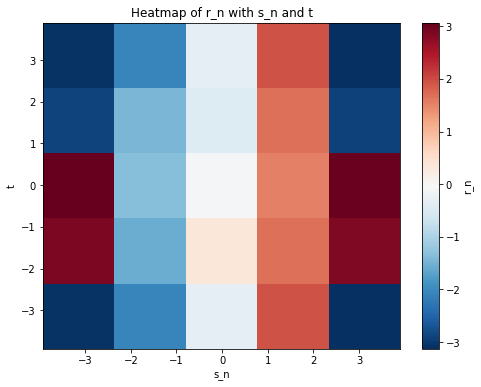

<Figure size 432x288 with 0 Axes>

In [14]:
num_means = 4
step=len(s_n)//num_means
indices = np.arange(0, s_n.shape[0], step=step)
mu_x_dim = len(indices)
s_n = s_n[indices][:, indices]
t = t[indices][:, indices]
r_n = r_n[indices][:, indices]
plots.heatmap_f_s_n_t(f_s_n_t=r_n, s_n=s_n, t=t, f_name='r_n')

In [15]:
s_n.shape, t.shape

((5, 5), (5, 5))

## Causal inference

### Convert means to internal space

In [16]:
s_n, t, r_n = s_n.flatten(), t.flatten(), r_n.flatten()
us_n = unif_map.angle_space_to_unif_space(s_n)
ut = unif_map.angle_space_to_unif_space(t)
print(f'Performing causal inference for ut, u_s_n of shape {ut.shape, us_n.shape}')

Performing causal inference for ut, u_s_n of shape ((25,), (25,))


### Create the grid and the prior over natural parameters

In [28]:
def get_nat_params(mus, kappas):
    nat_params = np.zeros((len(mus), len(kappas), 2))
    for i, mu in enumerate(mus):
        for j, kappa in enumerate(kappas):
            nat_params[i, j] = kappa * np.array([np.cos(mu), np.sin(mu)])
    return nat_params

def get_uniform_eta_prior(etas):
    return np.ones((etas.shape[0], etas.shape[1])) / (etas.shape[0]*etas.shape[1])


kappas = np.logspace(start=0, stop=np.log10(500), num=20, base=10)
mus = np.linspace(-np.pi, np.pi, num=20)
etas = get_nat_params(mus, kappas)
prior_eta = get_uniform_eta_prior(etas)
etas, prior_eta = etas.reshape((-1, 2)), prior_eta.flatten()

### Compute the likelihoods

In [29]:
def get_p_eta_common_cause(p_eta, etas, s_1, s_2):
    """
    Computes p(eta | s_1, s_2) for the common cause scenario.

    Parameters:
    - p_eta: Prior probabilities over eta, shape (e,)
    - etas: Natural parameters, shape (e, 2)
    - s_1: Means for the first cue, shape (n, m)
    - s_2: Means for the second cue, shape (n, m)

    Returns:
    - p_eta_given_s1_s2: shape (n, m, e)
    """
    # Compute mu and kappa from etas
    mu = np.arctan2(etas[:, 1], etas[:, 0])     # shape (e,)
    kappa = np.linalg.norm(etas, axis=1)        # shape (e,)

    # Reshape s_1 and s_2 for broadcasting
    s_1 = s_1[:, :, np.newaxis]                 # shape (n, m, 1)
    s_2 = s_2[:, :, np.newaxis]                 # shape (n, m, 1)

    # Reshape mu and kappa for broadcasting
    mu = mu[np.newaxis, np.newaxis, :]          # shape (1, 1, e)
    kappa = kappa[np.newaxis, np.newaxis, :]    # shape (1, 1, e)
    vm_pdf_s1 = vonmises.pdf(s_1, kappa, loc=mu)
    vm_pdf_s2 = vonmises.pdf(s_2, kappa, loc=mu)

    # Reshape p_eta for broadcasting
    p_eta = p_eta[np.newaxis, np.newaxis, :]    # shape (1, 1, e)

    # Compute p(\eta \mid s_1, s_2, C=1)
    p_eta_given_s1_s2 = vm_pdf_s1 * vm_pdf_s2 * p_eta  # shape (n, m, e)
    # Compute the sum over eta to normalize
    sum_over_eta = np.sum(p_eta_given_s1_s2, axis=2, keepdims=True)  # shape (n, m, 1)
    # Avoid division by zero
    sum_over_eta[sum_over_eta == 0] = 1e-10
    # Normalize the posterior probabilities
    p_eta_given_s1_s2_normalized = p_eta_given_s1_s2 / sum_over_eta      # shape (n, m, e)
    return p_eta_given_s1_s2_normalized

def get_p_eta_separate_cause(p_eta, etas, s):
    """
    Computes p(eta | s, C=2) for the separate cause scenario.

    Parameters:
    - p_eta: Prior probabilities over eta, shape (e,)
    - etas: Natural parameters, shape (e, 2)
    - s: Means of the cue, shape (n, m)

    Returns:
    - p_eta_given_s: shape (n, m, e)
    """
    # Compute mu and kappa from etas
    mu = np.arctan2(etas[:, 1], etas[:, 0])     # shape (e,)
    kappa = np.linalg.norm(etas, axis=1)        # shape (e,)

    # Reshape s for broadcasting
    s = s[:, :, np.newaxis]                     # shape (n, m, 1)

    # Reshape mu and kappa for broadcasting
    mu = mu[np.newaxis, np.newaxis, :]          # shape (1, 1, e)
    kappa = kappa[np.newaxis, np.newaxis, :]    # shape (1, 1, e)
    vm_pdf_s = vonmises.pdf(s, kappa, loc=mu)

    # Reshape p_eta for broadcasting
    p_eta = p_eta[np.newaxis, np.newaxis, :]    # shape (1, 1, e)

    # Compute p(\eta \mid s, C=2)
    p_eta_given_s = vm_pdf_s * p_eta            # shape (n, m, e)

    # Compute the sum over eta to normalize
    sum_over_eta = np.sum(p_eta_given_s, axis=2, keepdims=True)  # shape (n, m, 1)
    # Avoid division by zero
    sum_over_eta[sum_over_eta == 0] = 1e-10
    # Normalize the posterior probabilities
    p_eta_given_s_normalized = p_eta_given_s / sum_over_eta      # shape (n, m, e)
    return p_eta_given_s_normalized

In [45]:
def get_mean(p_eta, eta):
    exp_sum = p_eta.reshape(-1, 1)*eta
    return exp_sum.sum(axis=0)

In [30]:
p_eta_common_cause = get_p_eta_common_cause(p_eta=prior_eta, etas=etas,
                                            s_1=ut.reshape((5, 5)),
                                            s_2=us_n.reshape((5, 5)))
p_eta_separate_cause_t = get_p_eta_separate_cause(p_eta=prior_eta, etas=etas,
                                            s=ut.reshape((5, 5)))
p_eta_separate_cause_s = get_p_eta_separate_cause(p_eta=prior_eta, etas=etas,
                                            s=us_n.reshape((5, 5)))

In [52]:
for i1 in range(mu_x_dim):
    for i2 in range(mu_x_dim):
        eta_hat = get_mean(p_eta_common_cause[i1,i2], etas)
        print(np.linalg.norm(eta_hat), np.arctan2(eta_hat[1], eta_hat[0]), ut.reshape((5, 5))[i1, i2], us_n.reshape((5, 5))[i1, i2])

284.40316339983656 -3.141572906556094 -3.132328046463897 -3.132328046463897
1.8150418174282825 -2.4152768033533145 -3.132328046463897 -1.5825920017703348
0.08608946769857868 2.5402707434326945 -3.132328046463897 0.05616155368553866
1.9550598522321536 2.471363680343903 -3.132328046463897 1.6757819928537376
263.64424830774067 3.141550212574809 -3.132328046463897 3.1019386538799694
1.8150418174282825 -2.4152768033533145 -1.5825920017703348 -3.132328046463897
92.57340648406404 -1.496030799420594 -1.5825920017703348 -1.5825920017703348
1.684937278117787 -0.7657771929381049 -1.5825920017703348 0.05616155368553866
0.2024300791370559 -3.1139255066689735 -1.5825920017703348 1.6757819928537376
1.7380373404134588 -2.4441875751773496 -1.5825920017703348 3.1019386538799694
0.08608946769857868 2.5402707434326945 0.05616155368553866 -3.132328046463897
1.684937278117787 -0.7657771929381049 0.05616155368553866 -1.5825920017703348
67.66074919771485 0.14761056524195132 0.05616155368553866 0.0561615536855

### Simulate the inference by sampling the 2 internal estimates for each pair of means (and associated concentrations)

In [53]:
kappa1 = np.array([20, 50, 70, 100])
kappa2 = np.array([10, 40, 60, 90])

In [54]:
results = {
    'responses': [], 
    'posterior_p_common': [],
    'mean_t_est': [], 
    'mean_sn_est': []
}
results['num_sim'] = 10000
results['ut'] = ut
results['us_n'] = us_n
t_samples, s_n_samples = causal_inference_estimator.get_vm_samples(num_sim=results['num_sim'], 
                                                                    mu_t=ut, mu_s_n=us_n,
                                                                    kappa1=kappa1, 
                                                                    kappa2=kappa2)

In [55]:
for p_common in p_commons:
    responses, posterior_p_common, mean_t_est, mean_sn_est = causal_inference_estimator.forward(t_samples=t_samples,
                                                                                                s_n_samples=s_n_samples,
                                                                                                p_common=p_common,
                                                                                                kappa1=kappa1,
                                                                                                kappa2=kappa2)
    results['responses'].append(responses)
    results['posterior_p_common'].append(posterior_p_common)
    results['mean_t_est'].append(mean_t_est)
    results['mean_sn_est'].append(mean_sn_est)

Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Comput

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>